# OpenDrift

### Documentation

[https://github.com/opendrift/opendrift/wiki](https://github.com/opendrift/opendrift/wiki)

***

### Installation

`git clone https://github.com/OpenDrift/opendrift.git`

`python setup.py develop --user`

***

In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from glob import glob
from datetime import datetime, timedelta
from dateutil.parser import parse
from itertools import repeat
from salishsea_tools import viz_tools
from rotate_fields_python import rotate_fields
from tqdm import tqdm_notebook as tqdm
from IPython.display import HTML

from opendrift.readers import reader_netCDF_CF_unstructured
from opendrift.models.oceandrift import OceanDrift

%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['animation.html'] = 'html5'

***

### OceanDrift model

Required forcing

In [3]:
# OceanDrift require variables
OceanDrift.required_variables

['x_sea_water_velocity',
 'y_sea_water_velocity',
 'x_wind',
 'y_wind',
 'land_binary_mask']

***
### Prepare forcing files
Forcing must be gridded on lon/lat coordinates. The easiest way is to reshape everything onto a single spatial dimension and use `opendrift.readers.reader_netCDF_CF_unstructured`.

In [4]:
# Define paths
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'HRDPS': '/results/forcing/atmospheric/GEM2.5/operational',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'out': '/data/bmoorema/results/opendrift',
    'date_cutoff': '2016 Nov 21',
}
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
daterange = [parse(d) for d in ['2017 Nov 11', '2017 Nov 16']]

Prefix constructor for SalishSeaCast

In [5]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    fn = '_'.join([f'SalishSea_1{res}', *repeat(date.strftime('%Y%m%d'), 2)])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

Process SalishSeaCast

In [6]:
def process_NEMO(date, paths, mask):
    """
    """

    prefix = make_prefix(date, paths)
    NEMO_out = os.path.join(paths['out'], 'forcing', os.path.split(prefix)[-1] + '_opendrift.nc')
    if os.path.exists(NEMO_out):
        print(f'{NEMO_out} already exists! Skipping ...')
        return
    else:
        print(f'Processing {NEMO_out}')
        raw = []
        for k, key in zip(['U', 'V'], ['vozocrtx', 'vomecrty']):
            with xr.open_dataset(prefix + f'_grid_{k}.nc') as data:
                raw.append(data[key][:, 0, ...].values)
                if k is 'U': time = data.time_counter
        u, v = viz_tools.rotate_vel2(*viz_tools.unstagger(*raw), paths['coords'])
        tmask = mask.tmask[0, 0, 1:, 1:].values.reshape(-1).astype(bool)
        xr.Dataset(
            {
                'longitude': ('flat', mask.nav_lon[1:, 1:].values.reshape(-1)[tmask]),
                'latitude': ('flat', mask.nav_lat[1:, 1:].values.reshape(-1)[tmask]),
                'u': (['time_counter', 'flat'], u.reshape(time.size, -1)[:, tmask], {'standard_name': 'x_sea_water_velocity'}),
                'v': (['time_counter', 'flat'], v.reshape(time.size, -1)[:, tmask], {'standard_name': 'y_sea_water_velocity'}),
            },
            coords={'time_counter': time}
        ).to_netcdf(NEMO_out)

Process HRDPS

In [7]:
def process_HRDPS(date, paths):
    """
    """

    datestr = date.strftime('ops_y%Ym%md%d.nc')
    HRDPS_out = os.path.join(paths['out'], 'forcing', datestr)
    if os.path.exists(HRDPS_out):
        print(f'{HRDPS_out} already exists! Skipping ...')
        return
    else:
        print(f'Processing {HRDPS_out}')
        with xr.open_dataset(os.path.join(paths['HRDPS'], datestr)) as data:
            time = data.time_counter
            time.attrs['standard_name'] = 'time'
            xr.Dataset(
                {
                    'longitude': ('flat', data.nav_lon.values.reshape(-1)),
                    'latitude': ('flat', data.nav_lat.values.reshape(-1)),
                    'u_wind': (['time_counter', 'flat'], data.u_wind.values.reshape(time.size, -1), {'standard_name': 'x_wind'}),
                    'v_wind': (['time_counter', 'flat'], data.v_wind.values.reshape(time.size, -1), {'standard_name': 'y_wind'}),
                },
                coords={'time_counter': time},
            ).to_netcdf(HRDPS_out)

Loop processing

In [9]:
# Date range
for day in tqdm(range(np.diff(daterange)[0].days + 1)):
    date = daterange[0] + timedelta(days=day)
    process_NEMO(date, paths, mask)
    process_HRDPS(date, paths)

/data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/ops_y2017m11d11.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/ops_y2017m11d12.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/ops_y2017m11d13.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/ops_y2017m11d14.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc already exists! Skipping ...
/data/bmoorema/results/opendrift/forcing/ops_y2017m11d15.nc already exists

***

In [10]:
o = OceanDrift(loglevel=20)

14:15:57 INFO: OpenDriftSimulation initialised (version 1.0.6)


In [11]:
datestr = daterange[0].strftime('%Y%m')
filenames = sorted(glob(os.path.join(paths['out'], 'forcing', f'SalishSea_1h_{datestr}*')))
o.add_reader(reader_netCDF_CF_unstructured.Reader(filenames[0]))
o.add_readers_from_list(filenames[1:])

14:15:58 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc
14:15:58 INFO: Opening file with Dataset


In [24]:
o.seed_elements(
    [-123.30544, -123.25568], [49.10429, 49.03878], radius=[0, 1000], wind_drift_factor=0,
    time=[daterange[0], daterange[0]+timedelta(hours=24)], cone=True, number=240,
)

In [13]:
o.set_config('general:coastline_action', 'previous')
o.set_config('drift:scheme', 'runge-kutta4')
#o.set_config('general:use_basemap_landmask', False)

In [14]:
o.run(
    time_step=timedelta(seconds=90), time_step_output=timedelta(hours=1),
    duration=timedelta(days=np.diff(daterange)[0].days + 1),
    #outfile='/data/bmoorema/results/opendrift/results/test.nc',
)

14:16:03 INFO: Config validation OK
14:16:03 INFO: Fallback values will be used for the following variables which have no readers: 
14:16:03 INFO: 	x_wind: 0.000000
14:16:03 INFO: 	y_wind: 0.000000
14:16:03 INFO: Adding a dynamical landmask (resolution "h") based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:16:03 INFO: No display found. Using non-interactive Agg backend
14:16:11 INFO: Using existing reader for land_binary_mask
14:16:11 INFO: All points are in ocean
14:16:11 INFO: 2017-11-11 00:00:00 - step 1 of 5760 - 1 active elements (0 deactivated)
14:16:11 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc
14:16:11 INFO: Opening file with Dataset
14:16:11 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc
14:16:11 INFO: Opening file with Dataset
14:16:11 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_2

14:16:12 INFO: 2017-11-11 01:57:00 - step 79 of 5760 - 20 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 01:58:30 - step 80 of 5760 - 20 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:00:00 - step 81 of 5760 - 21 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:01:30 - step 82 of 5760 - 21 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:03:00 - step 83 of 5760 - 21 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:04:30 - step 84 of 5760 - 21 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:06:00 - step 85 of 5760 - 22 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:07:30 - step 86 of 5760 - 22 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:09:00 - step 87 of 5760 - 22 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:10:30 - step 88 of 5760 - 22 active elements (0 deactivated)
14:16:12 INFO: 2017-11-11 02:12:00 - step 89 of 5760 - 23 active elements (0 deactivated)
14:16:12 I

14:16:13 INFO: 2017-11-11 04:13:30 - step 170 of 5760 - 43 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:15:00 - step 171 of 5760 - 43 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:16:30 - step 172 of 5760 - 43 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:18:00 - step 173 of 5760 - 44 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:19:30 - step 174 of 5760 - 44 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:21:00 - step 175 of 5760 - 44 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:22:30 - step 176 of 5760 - 44 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:24:00 - step 177 of 5760 - 45 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:25:30 - step 178 of 5760 - 45 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:27:00 - step 179 of 5760 - 45 active elements (0 deactivated)
14:16:13 INFO: 2017-11-11 04:28:30 - step 180 of 5760 - 45 active elements (0 deactivated)

14:16:14 INFO: 2017-11-11 06:30:00 - step 261 of 5760 - 65 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:31:30 - step 262 of 5760 - 66 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:33:00 - step 263 of 5760 - 66 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:34:30 - step 264 of 5760 - 66 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:36:00 - step 265 of 5760 - 66 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:37:30 - step 266 of 5760 - 67 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:39:00 - step 267 of 5760 - 67 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:40:30 - step 268 of 5760 - 67 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:42:00 - step 269 of 5760 - 67 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:43:30 - step 270 of 5760 - 68 active elements (0 deactivated)
14:16:14 INFO: 2017-11-11 06:45:00 - step 271 of 5760 - 68 active elements (0 deactivated)

14:16:15 INFO: 2017-11-11 08:46:30 - step 352 of 5760 - 88 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:48:00 - step 353 of 5760 - 88 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:49:30 - step 354 of 5760 - 89 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:51:00 - step 355 of 5760 - 89 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:52:30 - step 356 of 5760 - 89 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:54:00 - step 357 of 5760 - 89 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:55:30 - step 358 of 5760 - 90 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:57:00 - step 359 of 5760 - 90 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 08:58:30 - step 360 of 5760 - 90 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 09:00:00 - step 361 of 5760 - 90 active elements (0 deactivated)
14:16:15 INFO: 2017-11-11 09:01:30 - step 362 of 5760 - 91 active elements (0 deactivated)

14:16:16 INFO: 2017-11-11 11:01:30 - step 442 of 5760 - 111 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:03:00 - step 443 of 5760 - 111 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:04:30 - step 444 of 5760 - 111 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:06:00 - step 445 of 5760 - 111 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:07:30 - step 446 of 5760 - 112 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:09:00 - step 447 of 5760 - 112 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:10:30 - step 448 of 5760 - 112 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:12:00 - step 449 of 5760 - 112 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:13:30 - step 450 of 5760 - 113 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:15:00 - step 451 of 5760 - 113 active elements (0 deactivated)
14:16:16 INFO: 2017-11-11 11:16:30 - step 452 of 5760 - 113 active elements (0 d

14:16:17 INFO: 2017-11-11 13:16:30 - step 532 of 5760 - 133 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:18:00 - step 533 of 5760 - 133 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:19:30 - step 534 of 5760 - 133 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:21:00 - step 535 of 5760 - 134 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:22:30 - step 536 of 5760 - 134 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:24:00 - step 537 of 5760 - 134 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:25:30 - step 538 of 5760 - 134 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:27:00 - step 539 of 5760 - 135 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:28:30 - step 540 of 5760 - 135 active elements (0 deactivated)
14:16:17 INFO: 2017-11-11 13:30:00 - step 541 of 5760 - 135 active elements (0 deactivated)
14:16:18 INFO: 2017-11-11 13:31:30 - step 542 of 5760 - 135 active elements (0 d

14:16:19 INFO: 2017-11-11 15:31:30 - step 622 of 5760 - 155 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:33:00 - step 623 of 5760 - 156 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:34:30 - step 624 of 5760 - 156 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:36:00 - step 625 of 5760 - 156 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:37:30 - step 626 of 5760 - 156 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:39:00 - step 627 of 5760 - 157 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:40:30 - step 628 of 5760 - 157 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:42:00 - step 629 of 5760 - 157 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:43:30 - step 630 of 5760 - 157 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:45:00 - step 631 of 5760 - 158 active elements (0 deactivated)
14:16:19 INFO: 2017-11-11 15:46:30 - step 632 of 5760 - 158 active elements (0 d

14:16:20 INFO: 2017-11-11 17:46:30 - step 712 of 5760 - 178 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:48:00 - step 713 of 5760 - 178 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:49:30 - step 714 of 5760 - 178 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:51:00 - step 715 of 5760 - 179 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:52:30 - step 716 of 5760 - 179 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:54:00 - step 717 of 5760 - 179 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:55:30 - step 718 of 5760 - 179 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:57:00 - step 719 of 5760 - 180 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 17:58:30 - step 720 of 5760 - 180 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 18:00:00 - step 721 of 5760 - 180 active elements (0 deactivated)
14:16:20 INFO: 2017-11-11 18:01:30 - step 722 of 5760 - 180 active elements (0 d

14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 INFO: 2017-11-11 18:27:00 - step 739 of 5760 - 184 active elements (0 deactivated)
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema

14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 INFO: 2017-11-11 18:40:30 - step 748 of 5760 - 187 active elements (0 deactivated)
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema

14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 INFO: 2017-11-11 18:54:00 - step 757 of 5760 - 189 active elements (0 deactivated)
14:16:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:20 WARNING: Data block from /data/bmoorema

14:16:21 INFO: 2017-11-11 19:06:00 - step 765 of 5760 - 191 active elements (0 deactivated)
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 INFO: 2017-11-11 19:07:30 - step 766 of

14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 INFO: 2017-11-11 19:19:30 - step 774 of 5760 - 193 active elements (0 deactivated)
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema

14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 INFO: 2017-11-11 19:33:00 - step 783 of 5760 - 195 active elements (0 deactivated)
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema

14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 INFO: 2017-11-11 19:46:30 - step 792 of 5760 - 198 active elements (0 deactivated)
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema

14:16:21 INFO: 2017-11-11 19:58:30 - step 800 of 5760 - 200 active elements (0 deactivated)
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 INFO: 2017-11-11 20:00:00 - step 801 of

14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 INFO: 2017-11-11 20:12:00 - step 809 of 5760 - 202 active elements (0 deactivated)
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema

14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 INFO: 2017-11-11 20:25:30 - step 818 of 5760 - 204 active elements (0 deactivated)
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:21 WARNING: Data block from /data/bmoorema

14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 INFO: 2017-11-11 20:39:00 - step 827 of 5760 - 206 active elements (0 deactivated)
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema

14:16:22 INFO: 2017-11-11 20:51:00 - step 835 of 5760 - 208 active elements (0 deactivated)
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 INFO: 2017-11-11 20:52:30 - step 836 of

14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 INFO: 2017-11-11 21:04:30 - step 844 of 5760 - 211 active elements (0 deactivated)
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema

14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 INFO: 2017-11-11 21:18:00 - step 853 of 5760 - 213 active elements (0 deactivated)
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema

14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 INFO: 2017-11-11 21:31:30 - step 862 of 5760 - 215 active elements (0 deactivated)
14:16:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:22 WARNING: Data block from /data/bmoorema

14:16:23 INFO: 2017-11-11 21:43:30 - step 870 of 5760 - 217 active elements (0 deactivated)
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 INFO: 2017-11-11 21:45:00 - step 871 of

14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 INFO: 2017-11-11 21:57:00 - step 879 of 5760 - 219 active elements (0 deactivated)
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema

14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 INFO: 2017-11-11 22:10:30 - step 888 of 5760 - 222 active elements (0 deactivated)
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema

14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 INFO: 2017-11-11 22:24:00 - step 897 of 5760 - 224 active elements (0 deactivated)
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema

14:16:23 INFO: 2017-11-11 22:36:00 - step 905 of 5760 - 226 active elements (0 deactivated)
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 INFO: 2017-11-11 22:37:30 - step 906 of

14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 INFO: 2017-11-11 22:49:30 - step 914 of 5760 - 228 active elements (0 deactivated)
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema

14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 INFO: 2017-11-11 23:03:00 - step 923 of 5760 - 230 active elements (0 deactivated)
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema

14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 INFO: 2017-11-11 23:16:30 - step 932 of 5760 - 233 active elements (0 deactivated)
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema

14:16:24 INFO: 2017-11-11 23:28:30 - step 940 of 5760 - 235 active elements (0 deactivated)
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 INFO: 2017-11-11 23:30:00 - step 941 of

14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 INFO: 2017-11-12 00:36:00 - step 985 of 5760 - 240 active elements (0 deactivated)
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema

14:16:24 INFO: 2017-11-12 00:48:00 - step 993 of 5760 - 240 active elements (0 deactivated)
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:24 INFO: 2017-11-12 00:49:30 - step 994 of

14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 INFO: 2017-11-12 01:01:30 - step 1002 of 5760 - 240 active elements (0 deactivated)
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorem

14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 INFO: 2017-11-12 01:15:00 - step 1011 of 5760 - 240 active elements (0 deactivated)
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorem

14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 INFO: 2017-11-12 01:28:30 - step 1020 of 5760 - 240 active elements (0 deactivated)
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorem

14:16:25 INFO: 2017-11-12 01:40:30 - step 1028 of 5760 - 240 active elements (0 deactivated)
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 INFO: 2017-11-12 01:42:00 - step 1029 

14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 INFO: 2017-11-12 01:54:00 - step 1037 of 5760 - 240 active elements (0 deactivated)
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorem

14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 INFO: 2017-11-12 02:07:30 - step 1046 of 5760 - 240 active elements (0 deactivated)
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:25 WARNING: Data block from /data/bmoorem

14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 INFO: 2017-11-12 02:21:00 - step 1055 of 5760 - 240 active elements (0 deactivated)
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorem

14:16:26 INFO: 2017-11-12 02:33:00 - step 1063 of 5760 - 240 active elements (0 deactivated)
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 INFO: 2017-11-12 02:34:30 - step 1064 

14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 INFO: 2017-11-12 02:46:30 - step 1072 of 5760 - 240 active elements (0 deactivated)
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorem

14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 INFO: 2017-11-12 03:00:00 - step 1081 of 5760 - 240 active elements (0 deactivated)
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorem

14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 INFO: 2017-11-12 03:13:30 - step 1090 of 5760 - 240 active elements (0 deactivated)
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorem

14:16:26 INFO: 2017-11-12 03:25:30 - step 1098 of 5760 - 240 active elements (0 deactivated)
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:26 INFO: 2017-11-12 03:27:00 - step 1099 

14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 INFO: 2017-11-12 03:39:00 - step 1107 of 5760 - 240 active elements (0 deactivated)
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorem

14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 INFO: 2017-11-12 03:52:30 - step 1116 of 5760 - 240 active elements (0 deactivated)
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorem

14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 INFO: 2017-11-12 04:06:00 - step 1125 of 5760 - 240 active elements (0 deactivated)
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorem

14:16:27 INFO: 2017-11-12 04:18:00 - step 1133 of 5760 - 240 active elements (0 deactivated)
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 INFO: 2017-11-12 04:19:30 - step 1134 

14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 INFO: 2017-11-12 04:31:30 - step 1142 of 5760 - 240 active elements (0 deactivated)
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorem

14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 INFO: 2017-11-12 04:45:00 - step 1151 of 5760 - 240 active elements (0 deactivated)
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:27 WARNING: Data block from /data/bmoorem

14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 INFO: 2017-11-12 04:58:30 - step 1160 of 5760 - 240 active elements (0 deactivated)
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorem

14:16:28 INFO: 2017-11-12 05:10:30 - step 1168 of 5760 - 240 active elements (0 deactivated)
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 INFO: 2017-11-12 05:12:00 - step 1169 

14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 INFO: 2017-11-12 05:24:00 - step 1177 of 5760 - 240 active elements (0 deactivated)
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorem

14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 INFO: 2017-11-12 05:37:30 - step 1186 of 5760 - 240 active elements (0 deactivated)
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorem

14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 INFO: 2017-11-12 05:51:00 - step 1195 of 5760 - 240 active elements (0 deactivated)
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorem

14:16:28 INFO: 2017-11-12 06:03:00 - step 1203 of 5760 - 240 active elements (0 deactivated)
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:28 INFO: 2017-11-12 06:04:30 - step 1204 

14:16:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 INFO: 2017-11-12 06:16:30 - step 1212 of 5760 - 240 active elements (0 deactivated)
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorem

14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 INFO: 2017-11-12 06:30:00 - step 1221 of 5760 - 240 active elements (0 deactivated)
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorem

14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 INFO: 2017-11-12 06:43:30 - step 1230 of 5760 - 240 active elements (0 deactivated)
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorem

14:16:29 INFO: 2017-11-12 06:55:30 - step 1238 of 5760 - 240 active elements (0 deactivated)
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 INFO: 2017-11-12 06:57:00 - step 1239 

14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 INFO: 2017-11-12 07:09:00 - step 1247 of 5760 - 240 active elements (0 deactivated)
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorem

14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 INFO: 2017-11-12 07:22:30 - step 1256 of 5760 - 240 active elements (0 deactivated)
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:29 WARNING: Data block from /data/bmoorem

14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 INFO: 2017-11-12 07:36:00 - step 1265 of 5760 - 240 active elements (0 deactivated)
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorem

14:16:30 INFO: 2017-11-12 07:48:00 - step 1273 of 5760 - 240 active elements (0 deactivated)
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 INFO: 2017-11-12 07:49:30 - step 1274 

14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 INFO: 2017-11-12 08:01:30 - step 1282 of 5760 - 240 active elements (0 deactivated)
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorem

14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 INFO: 2017-11-12 08:15:00 - step 1291 of 5760 - 240 active elements (0 deactivated)
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorem

14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 INFO: 2017-11-12 08:28:30 - step 1300 of 5760 - 240 active elements (0 deactivated)
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorem

14:16:30 INFO: 2017-11-12 08:40:30 - step 1308 of 5760 - 240 active elements (0 deactivated)
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:30 INFO: 2017-11-12 08:42:00 - step 1309 

14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 INFO: 2017-11-12 08:54:00 - step 1317 of 5760 - 240 active elements (0 deactivated)
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorem

14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 INFO: 2017-11-12 09:07:30 - step 1326 of 5760 - 240 active elements (0 deactivated)
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorem

14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 INFO: 2017-11-12 09:21:00 - step 1335 of 5760 - 240 active elements (0 deactivated)
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorem

14:16:31 INFO: 2017-11-12 09:33:00 - step 1343 of 5760 - 240 active elements (0 deactivated)
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 INFO: 2017-11-12 09:34:30 - step 1344 

14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 INFO: 2017-11-12 09:46:30 - step 1352 of 5760 - 240 active elements (0 deactivated)
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorem

14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 INFO: 2017-11-12 10:00:00 - step 1361 of 5760 - 240 active elements (0 deactivated)
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:31 WARNING: Data block from /data/bmoorem

14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 INFO: 2017-11-12 10:13:30 - step 1370 of 5760 - 240 active elements (0 deactivated)
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorem

14:16:32 INFO: 2017-11-12 10:25:30 - step 1378 of 5760 - 240 active elements (0 deactivated)
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 INFO: 2017-11-12 10:27:00 - step 1379 

14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 INFO: 2017-11-12 10:39:00 - step 1387 of 5760 - 240 active elements (0 deactivated)
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorem

14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 INFO: 2017-11-12 10:52:30 - step 1396 of 5760 - 240 active elements (0 deactivated)
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorem

14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 INFO: 2017-11-12 11:06:00 - step 1405 of 5760 - 240 active elements (0 deactivated)
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorem

14:16:32 INFO: 2017-11-12 11:18:00 - step 1413 of 5760 - 240 active elements (0 deactivated)
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:32 INFO: 2017-11-12 11:19:30 - step 1414 

14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 INFO: 2017-11-12 11:31:30 - step 1422 of 5760 - 240 active elements (0 deactivated)
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorem

14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 INFO: 2017-11-12 11:45:00 - step 1431 of 5760 - 240 active elements (0 deactivated)
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorem

14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 INFO: 2017-11-12 11:58:30 - step 1440 of 5760 - 240 active elements (0 deactivated)
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorem

14:16:33 INFO: 2017-11-12 12:10:30 - step 1448 of 5760 - 240 active elements (0 deactivated)
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 INFO: 2017-11-12 12:12:00 - step 1449 

14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 INFO: 2017-11-12 12:24:00 - step 1457 of 5760 - 240 active elements (0 deactivated)
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorem

14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 INFO: 2017-11-12 12:37:30 - step 1466 of 5760 - 240 active elements (0 deactivated)
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:33 WARNING: Data block from /data/bmoorem

14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 INFO: 2017-11-12 12:51:00 - step 1475 of 5760 - 240 active elements (0 deactivated)
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorem

14:16:34 INFO: 2017-11-12 13:03:00 - step 1483 of 5760 - 240 active elements (0 deactivated)
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 INFO: 2017-11-12 13:04:30 - step 1484 

14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 INFO: 2017-11-12 13:16:30 - step 1492 of 5760 - 240 active elements (0 deactivated)
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorem

14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 INFO: 2017-11-12 13:30:00 - step 1501 of 5760 - 240 active elements (0 deactivated)
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorem

14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 INFO: 2017-11-12 13:43:30 - step 1510 of 5760 - 240 active elements (0 deactivated)
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorem

14:16:34 INFO: 2017-11-12 13:55:30 - step 1518 of 5760 - 240 active elements (0 deactivated)
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:34 INFO: 2017-11-12 13:57:00 - step 1519 

14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 INFO: 2017-11-12 14:09:00 - step 1527 of 5760 - 240 active elements (0 deactivated)
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorem

14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 INFO: 2017-11-12 14:22:30 - step 1536 of 5760 - 240 active elements (0 deactivated)
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorem

14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 INFO: 2017-11-12 14:36:00 - step 1545 of 5760 - 240 active elements (0 deactivated)
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorem

14:16:35 INFO: 2017-11-12 14:48:00 - step 1553 of 5760 - 240 active elements (0 deactivated)
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 INFO: 2017-11-12 14:49:30 - step 1554 

14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 INFO: 2017-11-12 15:01:30 - step 1562 of 5760 - 240 active elements (0 deactivated)
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorem

14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 INFO: 2017-11-12 15:15:00 - step 1571 of 5760 - 240 active elements (0 deactivated)
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorem

14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 INFO: 2017-11-12 15:28:30 - step 1580 of 5760 - 240 active elements (0 deactivated)
14:16:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:35 WARNING: Data block from /data/bmoorem

14:16:36 INFO: 2017-11-12 15:40:30 - step 1588 of 5760 - 240 active elements (0 deactivated)
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 INFO: 2017-11-12 15:42:00 - step 1589 

14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 INFO: 2017-11-12 15:54:00 - step 1597 of 5760 - 240 active elements (0 deactivated)
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorem

14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 INFO: 2017-11-12 16:07:30 - step 1606 of 5760 - 240 active elements (0 deactivated)
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorem

14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 INFO: 2017-11-12 16:21:00 - step 1615 of 5760 - 240 active elements (0 deactivated)
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorem

14:16:36 INFO: 2017-11-12 16:33:00 - step 1623 of 5760 - 240 active elements (0 deactivated)
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:36 INFO: 2017-11-12 16:34:30 - step 1624 

14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 INFO: 2017-11-12 16:46:30 - step 1632 of 5760 - 240 active elements (0 deactivated)
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorem

14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 INFO: 2017-11-12 17:00:00 - step 1641 of 5760 - 240 active elements (0 deactivated)
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorem

14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 INFO: 2017-11-12 17:13:30 - step 1650 of 5760 - 240 active elements (0 deactivated)
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorem

14:16:37 INFO: 2017-11-12 17:25:30 - step 1658 of 5760 - 240 active elements (0 deactivated)
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 INFO: 2017-11-12 17:27:00 - step 1659 

14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 INFO: 2017-11-12 17:39:00 - step 1667 of 5760 - 240 active elements (0 deactivated)
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorem

14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 INFO: 2017-11-12 17:52:30 - step 1676 of 5760 - 240 active elements (0 deactivated)
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:37 WARNING: Data block from /data/bmoorem

14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 INFO: 2017-11-12 18:06:00 - step 1685 of 5760 - 240 active elements (0 deactivated)
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorem

14:16:38 INFO: 2017-11-12 18:18:00 - step 1693 of 5760 - 240 active elements (0 deactivated)
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 INFO: 2017-11-12 18:19:30 - step 1694 

14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 INFO: 2017-11-12 18:31:30 - step 1702 of 5760 - 240 active elements (0 deactivated)
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorem

14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 INFO: 2017-11-12 18:45:00 - step 1711 of 5760 - 240 active elements (0 deactivated)
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorem

14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 INFO: 2017-11-12 18:58:30 - step 1720 of 5760 - 240 active elements (0 deactivated)
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorem

14:16:38 INFO: 2017-11-12 19:10:30 - step 1728 of 5760 - 240 active elements (0 deactivated)
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 INFO: 2017-11-12 19:12:00 - step 1729 

14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 INFO: 2017-11-12 19:24:00 - step 1737 of 5760 - 240 active elements (0 deactivated)
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:38 WARNING: Data block from /data/bmoorem

14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 INFO: 2017-11-12 19:37:30 - step 1746 of 5760 - 240 active elements (0 deactivated)
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorem

14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 INFO: 2017-11-12 19:51:00 - step 1755 of 5760 - 240 active elements (0 deactivated)
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorem

14:16:39 INFO: 2017-11-12 20:03:00 - step 1763 of 5760 - 240 active elements (0 deactivated)
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 INFO: 2017-11-12 20:04:30 - step 1764 

14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 INFO: 2017-11-12 20:16:30 - step 1772 of 5760 - 240 active elements (0 deactivated)
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorem

14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 INFO: 2017-11-12 20:30:00 - step 1781 of 5760 - 240 active elements (0 deactivated)
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:39 WARNING: Data block from /data/bmoorem

14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 INFO: 2017-11-12 20:43:30 - step 1790 of 5760 - 240 active elements (0 deactivated)
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorem

14:16:40 INFO: 2017-11-12 20:55:30 - step 1798 of 5760 - 240 active elements (0 deactivated)
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 INFO: 2017-11-12 20:57:00 - step 1799 

14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 INFO: 2017-11-12 21:09:00 - step 1807 of 5760 - 240 active elements (0 deactivated)
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorem

14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 INFO: 2017-11-12 21:22:30 - step 1816 of 5760 - 240 active elements (0 deactivated)
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorem

14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 INFO: 2017-11-12 21:36:00 - step 1825 of 5760 - 240 active elements (0 deactivated)
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorem

14:16:40 INFO: 2017-11-12 21:48:00 - step 1833 of 5760 - 240 active elements (0 deactivated)
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 INFO: 2017-11-12 21:49:30 - step 1834 

14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 INFO: 2017-11-12 22:01:30 - step 1842 of 5760 - 240 active elements (0 deactivated)
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:40 WARNING: Data block from /data/bmoorem

14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 INFO: 2017-11-12 22:15:00 - step 1851 of 5760 - 240 active elements (0 deactivated)
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorem

14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 INFO: 2017-11-12 22:28:30 - step 1860 of 5760 - 240 active elements (0 deactivated)
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorem

14:16:41 INFO: 2017-11-12 22:40:30 - step 1868 of 5760 - 240 active elements (0 deactivated)
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 INFO: 2017-11-12 22:42:00 - step 1869 

14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 INFO: 2017-11-12 22:54:00 - step 1877 of 5760 - 240 active elements (0 deactivated)
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorem

14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 INFO: 2017-11-12 23:07:30 - step 1886 of 5760 - 240 active elements (0 deactivated)
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorem

14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 INFO: 2017-11-12 23:21:00 - step 1895 of 5760 - 240 active elements (0 deactivated)
14:16:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171112_20171112_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:41 WARNING: Data block from /data/bmoorem

14:16:42 INFO: 2017-11-12 23:57:00 - step 1919 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-12 23:58:30 - step 1920 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:00:00 - step 1921 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:01:30 - step 1922 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:03:00 - step 1923 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:04:30 - step 1924 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:06:00 - step 1925 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:07:30 - step 1926 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:09:00 - step 1927 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:10:30 - step 1928 of 5760 - 240 active elements (0 deactivated)
14:16:42 INFO: 2017-11-13 00:12:00 - step 1929 of 5760 - 240 active el

14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 INFO: 2017-11-13 00:40:30 - step 1948 of 5760 - 240 active elements (0 deactivated)
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorem

14:16:42 INFO: 2017-11-13 00:52:30 - step 1956 of 5760 - 240 active elements (0 deactivated)
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 INFO: 2017-11-13 00:54:00 - step 1957 

14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 INFO: 2017-11-13 01:06:00 - step 1965 of 5760 - 240 active elements (0 deactivated)
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:42 WARNING: Data block from /data/bmoorem

14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 INFO: 2017-11-13 01:19:30 - step 1974 of 5760 - 240 active elements (0 deactivated)
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorem

14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 INFO: 2017-11-13 01:33:00 - step 1983 of 5760 - 240 active elements (0 deactivated)
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorem

14:16:43 INFO: 2017-11-13 01:45:00 - step 1991 of 5760 - 240 active elements (0 deactivated)
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 INFO: 2017-11-13 01:46:30 - step 1992 

14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 INFO: 2017-11-13 01:58:30 - step 2000 of 5760 - 240 active elements (0 deactivated)
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorem

14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 INFO: 2017-11-13 02:12:00 - step 2009 of 5760 - 240 active elements (0 deactivated)
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorem

14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 INFO: 2017-11-13 02:25:30 - step 2018 of 5760 - 240 active elements (0 deactivated)
14:16:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:43 WARNING: Data block from /data/bmoorem

14:16:44 INFO: 2017-11-13 02:37:30 - step 2026 of 5760 - 240 active elements (0 deactivated)
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 INFO: 2017-11-13 02:39:00 - step 2027 

14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 INFO: 2017-11-13 02:51:00 - step 2035 of 5760 - 240 active elements (0 deactivated)
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorem

14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 INFO: 2017-11-13 03:04:30 - step 2044 of 5760 - 240 active elements (0 deactivated)
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorem

14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 INFO: 2017-11-13 03:18:00 - step 2053 of 5760 - 240 active elements (0 deactivated)
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorem

14:16:44 INFO: 2017-11-13 03:30:00 - step 2061 of 5760 - 240 active elements (0 deactivated)
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 INFO: 2017-11-13 03:31:30 - step 2062 

14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 INFO: 2017-11-13 03:43:30 - step 2070 of 5760 - 240 active elements (0 deactivated)
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:44 WARNING: Data block from /data/bmoorem

14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 INFO: 2017-11-13 03:57:00 - step 2079 of 5760 - 240 active elements (0 deactivated)
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorem

14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 INFO: 2017-11-13 04:10:30 - step 2088 of 5760 - 240 active elements (0 deactivated)
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorem

14:16:45 INFO: 2017-11-13 04:22:30 - step 2096 of 5760 - 240 active elements (0 deactivated)
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 INFO: 2017-11-13 04:24:00 - step 2097 

14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 INFO: 2017-11-13 04:36:00 - step 2105 of 5760 - 240 active elements (0 deactivated)
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorem

14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 INFO: 2017-11-13 04:49:30 - step 2114 of 5760 - 240 active elements (0 deactivated)
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:45 WARNING: Data block from /data/bmoorem

14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 INFO: 2017-11-13 05:03:00 - step 2123 of 5760 - 240 active elements (0 deactivated)
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorem

14:16:46 INFO: 2017-11-13 05:15:00 - step 2131 of 5760 - 240 active elements (0 deactivated)
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 INFO: 2017-11-13 05:16:30 - step 2132 

14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 INFO: 2017-11-13 05:28:30 - step 2140 of 5760 - 240 active elements (0 deactivated)
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorem

14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 INFO: 2017-11-13 05:42:00 - step 2149 of 5760 - 240 active elements (0 deactivated)
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorem

14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 INFO: 2017-11-13 05:55:30 - step 2158 of 5760 - 240 active elements (0 deactivated)
14:16:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:46 WARNING: Data block from /data/bmoorem

14:16:47 INFO: 2017-11-13 06:07:30 - step 2166 of 5760 - 240 active elements (0 deactivated)
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 INFO: 2017-11-13 06:09:00 - step 2167 

14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 INFO: 2017-11-13 06:21:00 - step 2175 of 5760 - 240 active elements (0 deactivated)
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorem

14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 INFO: 2017-11-13 06:34:30 - step 2184 of 5760 - 240 active elements (0 deactivated)
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorem

14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 INFO: 2017-11-13 06:48:00 - step 2193 of 5760 - 240 active elements (0 deactivated)
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorem

14:16:47 INFO: 2017-11-13 07:00:00 - step 2201 of 5760 - 240 active elements (0 deactivated)
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:47 INFO: 2017-11-13 07:01:30 - step 2202 

14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 INFO: 2017-11-13 07:13:30 - step 2210 of 5760 - 240 active elements (0 deactivated)
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorem

14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 INFO: 2017-11-13 07:27:00 - step 2219 of 5760 - 240 active elements (0 deactivated)
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorem

14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 INFO: 2017-11-13 07:40:30 - step 2228 of 5760 - 240 active elements (0 deactivated)
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorem

14:16:48 INFO: 2017-11-13 07:52:30 - step 2236 of 5760 - 240 active elements (0 deactivated)
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 INFO: 2017-11-13 07:54:00 - step 2237 

14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 INFO: 2017-11-13 08:06:00 - step 2245 of 5760 - 240 active elements (0 deactivated)
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:48 WARNING: Data block from /data/bmoorem

14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 INFO: 2017-11-13 08:19:30 - step 2254 of 5760 - 240 active elements (0 deactivated)
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorem

14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 INFO: 2017-11-13 08:33:00 - step 2263 of 5760 - 240 active elements (0 deactivated)
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorem

14:16:49 INFO: 2017-11-13 08:45:00 - step 2271 of 5760 - 240 active elements (0 deactivated)
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 INFO: 2017-11-13 08:46:30 - step 2272 

14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 INFO: 2017-11-13 08:58:30 - step 2280 of 5760 - 240 active elements (0 deactivated)
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorem

14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 INFO: 2017-11-13 09:12:00 - step 2289 of 5760 - 240 active elements (0 deactivated)
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:49 WARNING: Data block from /data/bmoorem

14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 INFO: 2017-11-13 09:25:30 - step 2298 of 5760 - 240 active elements (0 deactivated)
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorem

14:16:50 INFO: 2017-11-13 09:37:30 - step 2306 of 5760 - 240 active elements (0 deactivated)
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 INFO: 2017-11-13 09:39:00 - step 2307 

14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 INFO: 2017-11-13 09:51:00 - step 2315 of 5760 - 240 active elements (0 deactivated)
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorem

14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 INFO: 2017-11-13 10:04:30 - step 2324 of 5760 - 240 active elements (0 deactivated)
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorem

14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 INFO: 2017-11-13 10:18:00 - step 2333 of 5760 - 240 active elements (0 deactivated)
14:16:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:50 WARNING: Data block from /data/bmoorem

14:16:51 INFO: 2017-11-13 10:30:00 - step 2341 of 5760 - 240 active elements (0 deactivated)
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 INFO: 2017-11-13 10:31:30 - step 2342 

14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 INFO: 2017-11-13 10:43:30 - step 2350 of 5760 - 240 active elements (0 deactivated)
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorem

14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 INFO: 2017-11-13 10:57:00 - step 2359 of 5760 - 240 active elements (0 deactivated)
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorem

14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 INFO: 2017-11-13 11:10:30 - step 2368 of 5760 - 240 active elements (0 deactivated)
14:16:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:51 WARNING: Data block from /data/bmoorem

14:16:52 INFO: 2017-11-13 11:22:30 - step 2376 of 5760 - 240 active elements (0 deactivated)
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 INFO: 2017-11-13 11:24:00 - step 2377 

14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 INFO: 2017-11-13 11:36:00 - step 2385 of 5760 - 240 active elements (0 deactivated)
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorem

14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 INFO: 2017-11-13 11:49:30 - step 2394 of 5760 - 240 active elements (0 deactivated)
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorem

14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 INFO: 2017-11-13 12:03:00 - step 2403 of 5760 - 240 active elements (0 deactivated)
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorem

14:16:52 INFO: 2017-11-13 12:15:00 - step 2411 of 5760 - 240 active elements (0 deactivated)
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:52 INFO: 2017-11-13 12:16:30 - step 2412 

14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 INFO: 2017-11-13 12:28:30 - step 2420 of 5760 - 240 active elements (0 deactivated)
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorem

14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 INFO: 2017-11-13 12:42:00 - step 2429 of 5760 - 240 active elements (0 deactivated)
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorem

14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 INFO: 2017-11-13 12:55:30 - step 2438 of 5760 - 240 active elements (0 deactivated)
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorem

14:16:53 INFO: 2017-11-13 13:07:30 - step 2446 of 5760 - 240 active elements (0 deactivated)
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:53 INFO: 2017-11-13 13:09:00 - step 2447 

14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 INFO: 2017-11-13 13:21:00 - step 2455 of 5760 - 240 active elements (0 deactivated)
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorem

14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 INFO: 2017-11-13 13:34:30 - step 2464 of 5760 - 240 active elements (0 deactivated)
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorem

14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 INFO: 2017-11-13 13:48:00 - step 2473 of 5760 - 240 active elements (0 deactivated)
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorem

14:16:54 INFO: 2017-11-13 14:00:00 - step 2481 of 5760 - 240 active elements (0 deactivated)
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 INFO: 2017-11-13 14:01:30 - step 2482 

14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 INFO: 2017-11-13 14:13:30 - step 2490 of 5760 - 240 active elements (0 deactivated)
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:54 WARNING: Data block from /data/bmoorem

14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 INFO: 2017-11-13 14:27:00 - step 2499 of 5760 - 240 active elements (0 deactivated)
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorem

14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 INFO: 2017-11-13 14:40:30 - step 2508 of 5760 - 240 active elements (0 deactivated)
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorem

14:16:55 INFO: 2017-11-13 14:52:30 - step 2516 of 5760 - 240 active elements (0 deactivated)
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 INFO: 2017-11-13 14:54:00 - step 2517 

14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 INFO: 2017-11-13 15:06:00 - step 2525 of 5760 - 240 active elements (0 deactivated)
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:55 WARNING: Data block from /data/bmoorem

14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 INFO: 2017-11-13 15:19:30 - step 2534 of 5760 - 240 active elements (0 deactivated)
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorem

14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 INFO: 2017-11-13 15:33:00 - step 2543 of 5760 - 240 active elements (0 deactivated)
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorem

14:16:56 INFO: 2017-11-13 15:45:00 - step 2551 of 5760 - 240 active elements (0 deactivated)
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 INFO: 2017-11-13 15:46:30 - step 2552 

14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 INFO: 2017-11-13 15:58:30 - step 2560 of 5760 - 240 active elements (0 deactivated)
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:56 WARNING: Data block from /data/bmoorem

14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 INFO: 2017-11-13 16:12:00 - step 2569 of 5760 - 240 active elements (0 deactivated)
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorem

14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 INFO: 2017-11-13 16:25:30 - step 2578 of 5760 - 240 active elements (0 deactivated)
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorem

14:16:57 INFO: 2017-11-13 16:37:30 - step 2586 of 5760 - 240 active elements (0 deactivated)
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 INFO: 2017-11-13 16:39:00 - step 2587 

14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 INFO: 2017-11-13 16:51:00 - step 2595 of 5760 - 240 active elements (0 deactivated)
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:57 WARNING: Data block from /data/bmoorem

14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 INFO: 2017-11-13 17:04:30 - step 2604 of 5760 - 240 active elements (0 deactivated)
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorem

14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 INFO: 2017-11-13 17:18:00 - step 2613 of 5760 - 240 active elements (0 deactivated)
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorem

14:16:58 INFO: 2017-11-13 17:30:00 - step 2621 of 5760 - 240 active elements (0 deactivated)
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:58 INFO: 2017-11-13 17:31:30 - step 2622 

14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 INFO: 2017-11-13 17:43:30 - step 2630 of 5760 - 240 active elements (0 deactivated)
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorem

14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 INFO: 2017-11-13 17:57:00 - step 2639 of 5760 - 240 active elements (0 deactivated)
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorem

14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 INFO: 2017-11-13 18:10:30 - step 2648 of 5760 - 240 active elements (0 deactivated)
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorem

14:16:59 INFO: 2017-11-13 18:22:30 - step 2656 of 5760 - 240 active elements (0 deactivated)
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:16:59 INFO: 2017-11-13 18:24:00 - step 2657 

14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 INFO: 2017-11-13 18:36:00 - step 2665 of 5760 - 240 active elements (0 deactivated)
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorem

14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 INFO: 2017-11-13 18:49:30 - step 2674 of 5760 - 240 active elements (0 deactivated)
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorem

14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 INFO: 2017-11-13 19:03:00 - step 2683 of 5760 - 240 active elements (0 deactivated)
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorem

14:17:00 INFO: 2017-11-13 19:15:00 - step 2691 of 5760 - 240 active elements (0 deactivated)
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:00 INFO: 2017-11-13 19:16:30 - step 2692 

14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 INFO: 2017-11-13 19:28:30 - step 2700 of 5760 - 240 active elements (0 deactivated)
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorem

14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 INFO: 2017-11-13 19:42:00 - step 2709 of 5760 - 240 active elements (0 deactivated)
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorem

14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 INFO: 2017-11-13 19:55:30 - step 2718 of 5760 - 240 active elements (0 deactivated)
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorem

14:17:01 INFO: 2017-11-13 20:07:30 - step 2726 of 5760 - 240 active elements (0 deactivated)
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:01 INFO: 2017-11-13 20:09:00 - step 2727 

14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 INFO: 2017-11-13 20:21:00 - step 2735 of 5760 - 240 active elements (0 deactivated)
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorem

14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 INFO: 2017-11-13 20:34:30 - step 2744 of 5760 - 240 active elements (0 deactivated)
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorem

14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 INFO: 2017-11-13 20:48:00 - step 2753 of 5760 - 240 active elements (0 deactivated)
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorem

14:17:02 INFO: 2017-11-13 21:00:00 - step 2761 of 5760 - 240 active elements (0 deactivated)
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:02 INFO: 2017-11-13 21:01:30 - step 2762 

14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 INFO: 2017-11-13 21:13:30 - step 2770 of 5760 - 240 active elements (0 deactivated)
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorem

14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 INFO: 2017-11-13 21:27:00 - step 2779 of 5760 - 240 active elements (0 deactivated)
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorem

14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 INFO: 2017-11-13 21:40:30 - step 2788 of 5760 - 240 active elements (0 deactivated)
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorem

14:17:03 INFO: 2017-11-13 21:52:30 - step 2796 of 5760 - 240 active elements (0 deactivated)
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:03 INFO: 2017-11-13 21:54:00 - step 2797 

14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 INFO: 2017-11-13 22:06:00 - step 2805 of 5760 - 240 active elements (0 deactivated)
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorem

14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 INFO: 2017-11-13 22:19:30 - step 2814 of 5760 - 240 active elements (0 deactivated)
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorem

14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 INFO: 2017-11-13 22:33:00 - step 2823 of 5760 - 240 active elements (0 deactivated)
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorem

14:17:04 INFO: 2017-11-13 22:45:00 - step 2831 of 5760 - 240 active elements (0 deactivated)
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:04 INFO: 2017-11-13 22:46:30 - step 2832 

14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 INFO: 2017-11-13 22:58:30 - step 2840 of 5760 - 240 active elements (0 deactivated)
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorem

14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 INFO: 2017-11-13 23:12:00 - step 2849 of 5760 - 240 active elements (0 deactivated)
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorem

14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 INFO: 2017-11-13 23:25:30 - step 2858 of 5760 - 240 active elements (0 deactivated)
14:17:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171113_20171113_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:05 WARNING: Data block from /data/bmoorem

14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 INFO: 2017-11-14 00:31:30 - step 2902 of 5760 - 240 active elements (0 deactivated)
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorem

14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 INFO: 2017-11-14 00:45:00 - step 2911 of 5760 - 240 active elements (0 deactivated)
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorem

14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:06 INFO: 2017-11-14 00:58:30 - step 2920 of 5760 - 240 active elements (0 deactivated)
14:17:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorem

14:17:07 INFO: 2017-11-14 01:10:30 - step 2928 of 5760 - 240 active elements (0 deactivated)
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 INFO: 2017-11-14 01:12:00 - step 2929 

14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 INFO: 2017-11-14 01:24:00 - step 2937 of 5760 - 240 active elements (0 deactivated)
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorem

14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 INFO: 2017-11-14 01:37:30 - step 2946 of 5760 - 240 active elements (0 deactivated)
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorem

14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 INFO: 2017-11-14 01:51:00 - step 2955 of 5760 - 240 active elements (0 deactivated)
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorem

14:17:08 INFO: 2017-11-14 02:03:00 - step 2963 of 5760 - 240 active elements (0 deactivated)
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 INFO: 2017-11-14 02:04:30 - step 2964 

14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 INFO: 2017-11-14 02:16:30 - step 2972 of 5760 - 240 active elements (0 deactivated)
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorem

14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 INFO: 2017-11-14 02:30:00 - step 2981 of 5760 - 240 active elements (0 deactivated)
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorem

14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:08 INFO: 2017-11-14 02:43:30 - step 2990 of 5760 - 240 active elements (0 deactivated)
14:17:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorem

14:17:09 INFO: 2017-11-14 02:55:30 - step 2998 of 5760 - 240 active elements (0 deactivated)
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 INFO: 2017-11-14 02:57:00 - step 2999 

14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 INFO: 2017-11-14 03:09:00 - step 3007 of 5760 - 240 active elements (0 deactivated)
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorem

14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 INFO: 2017-11-14 03:22:30 - step 3016 of 5760 - 240 active elements (0 deactivated)
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:09 WARNING: Data block from /data/bmoorem

14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 INFO: 2017-11-14 03:36:00 - step 3025 of 5760 - 240 active elements (0 deactivated)
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorem

14:17:10 INFO: 2017-11-14 03:48:00 - step 3033 of 5760 - 240 active elements (0 deactivated)
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 INFO: 2017-11-14 03:49:30 - step 3034 

14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 INFO: 2017-11-14 04:01:30 - step 3042 of 5760 - 240 active elements (0 deactivated)
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorem

14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 INFO: 2017-11-14 04:15:00 - step 3051 of 5760 - 240 active elements (0 deactivated)
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:10 WARNING: Data block from /data/bmoorem

14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 INFO: 2017-11-14 04:28:30 - step 3060 of 5760 - 240 active elements (0 deactivated)
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorem

14:17:11 INFO: 2017-11-14 04:40:30 - step 3068 of 5760 - 240 active elements (0 deactivated)
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 INFO: 2017-11-14 04:42:00 - step 3069 

14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 INFO: 2017-11-14 04:54:00 - step 3077 of 5760 - 240 active elements (0 deactivated)
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:11 WARNING: Data block from /data/bmoorem

14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 INFO: 2017-11-14 05:07:30 - step 3086 of 5760 - 240 active elements (0 deactivated)
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorem

14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 INFO: 2017-11-14 05:21:00 - step 3095 of 5760 - 240 active elements (0 deactivated)
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorem

14:17:12 INFO: 2017-11-14 05:33:00 - step 3103 of 5760 - 240 active elements (0 deactivated)
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 INFO: 2017-11-14 05:34:30 - step 3104 

14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 INFO: 2017-11-14 05:46:30 - step 3112 of 5760 - 240 active elements (0 deactivated)
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:12 WARNING: Data block from /data/bmoorem

14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 INFO: 2017-11-14 06:00:00 - step 3121 of 5760 - 240 active elements (0 deactivated)
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorem

14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 INFO: 2017-11-14 06:13:30 - step 3130 of 5760 - 240 active elements (0 deactivated)
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorem

14:17:13 INFO: 2017-11-14 06:25:30 - step 3138 of 5760 - 240 active elements (0 deactivated)
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 INFO: 2017-11-14 06:27:00 - step 3139 

14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 INFO: 2017-11-14 06:39:00 - step 3147 of 5760 - 240 active elements (0 deactivated)
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:13 WARNING: Data block from /data/bmoorem

14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 INFO: 2017-11-14 06:52:30 - step 3156 of 5760 - 240 active elements (0 deactivated)
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorem

14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 INFO: 2017-11-14 07:06:00 - step 3165 of 5760 - 240 active elements (0 deactivated)
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorem

14:17:14 INFO: 2017-11-14 07:18:00 - step 3173 of 5760 - 240 active elements (0 deactivated)
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 INFO: 2017-11-14 07:19:30 - step 3174 

14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 INFO: 2017-11-14 07:31:30 - step 3182 of 5760 - 240 active elements (0 deactivated)
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorem

14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 INFO: 2017-11-14 07:45:00 - step 3191 of 5760 - 240 active elements (0 deactivated)
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:14 WARNING: Data block from /data/bmoorem

14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 INFO: 2017-11-14 07:58:30 - step 3200 of 5760 - 240 active elements (0 deactivated)
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorem

14:17:15 INFO: 2017-11-14 08:10:30 - step 3208 of 5760 - 240 active elements (0 deactivated)
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 INFO: 2017-11-14 08:12:00 - step 3209 

14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 INFO: 2017-11-14 08:24:00 - step 3217 of 5760 - 240 active elements (0 deactivated)
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorem

14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 INFO: 2017-11-14 08:37:30 - step 3226 of 5760 - 240 active elements (0 deactivated)
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorem

14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:15 INFO: 2017-11-14 08:51:00 - step 3235 of 5760 - 240 active elements (0 deactivated)
14:17:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorem

14:17:16 INFO: 2017-11-14 09:03:00 - step 3243 of 5760 - 240 active elements (0 deactivated)
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 INFO: 2017-11-14 09:04:30 - step 3244 

14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 INFO: 2017-11-14 09:16:30 - step 3252 of 5760 - 240 active elements (0 deactivated)
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorem

14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 INFO: 2017-11-14 09:30:00 - step 3261 of 5760 - 240 active elements (0 deactivated)
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorem

14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 INFO: 2017-11-14 09:43:30 - step 3270 of 5760 - 240 active elements (0 deactivated)
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:16 WARNING: Data block from /data/bmoorem

14:17:16 INFO: 2017-11-14 09:55:30 - step 3278 of 5760 - 240 active elements (0 deactivated)
14:17:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 INFO: 2017-11-14 09:57:00 - step 3279 

14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 INFO: 2017-11-14 10:09:00 - step 3287 of 5760 - 240 active elements (0 deactivated)
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorem

14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 INFO: 2017-11-14 10:22:30 - step 3296 of 5760 - 240 active elements (0 deactivated)
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorem

14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 INFO: 2017-11-14 10:36:00 - step 3305 of 5760 - 240 active elements (0 deactivated)
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorem

14:17:17 INFO: 2017-11-14 10:48:00 - step 3313 of 5760 - 240 active elements (0 deactivated)
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:17 INFO: 2017-11-14 10:49:30 - step 3314 

14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 INFO: 2017-11-14 11:01:30 - step 3322 of 5760 - 240 active elements (0 deactivated)
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorem

14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 INFO: 2017-11-14 11:15:00 - step 3331 of 5760 - 240 active elements (0 deactivated)
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorem

14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 INFO: 2017-11-14 11:28:30 - step 3340 of 5760 - 240 active elements (0 deactivated)
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorem

14:17:18 INFO: 2017-11-14 11:40:30 - step 3348 of 5760 - 240 active elements (0 deactivated)
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 INFO: 2017-11-14 11:42:00 - step 3349 

14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 INFO: 2017-11-14 11:54:00 - step 3357 of 5760 - 240 active elements (0 deactivated)
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:18 WARNING: Data block from /data/bmoorem

14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 INFO: 2017-11-14 12:07:30 - step 3366 of 5760 - 240 active elements (0 deactivated)
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorem

14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 INFO: 2017-11-14 12:21:00 - step 3375 of 5760 - 240 active elements (0 deactivated)
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorem

14:17:19 INFO: 2017-11-14 12:33:00 - step 3383 of 5760 - 240 active elements (0 deactivated)
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 INFO: 2017-11-14 12:34:30 - step 3384 

14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 INFO: 2017-11-14 12:46:30 - step 3392 of 5760 - 240 active elements (0 deactivated)
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorem

14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 INFO: 2017-11-14 13:00:00 - step 3401 of 5760 - 240 active elements (0 deactivated)
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:19 WARNING: Data block from /data/bmoorem

14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 INFO: 2017-11-14 13:13:30 - step 3410 of 5760 - 240 active elements (0 deactivated)
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorem

14:17:20 INFO: 2017-11-14 13:25:30 - step 3418 of 5760 - 240 active elements (0 deactivated)
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 INFO: 2017-11-14 13:27:00 - step 3419 

14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 INFO: 2017-11-14 13:39:00 - step 3427 of 5760 - 240 active elements (0 deactivated)
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorem

14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 INFO: 2017-11-14 13:52:30 - step 3436 of 5760 - 240 active elements (0 deactivated)
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorem

14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 INFO: 2017-11-14 14:06:00 - step 3445 of 5760 - 240 active elements (0 deactivated)
14:17:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:20 WARNING: Data block from /data/bmoorem

14:17:21 INFO: 2017-11-14 14:18:00 - step 3453 of 5760 - 240 active elements (0 deactivated)
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 INFO: 2017-11-14 14:19:30 - step 3454 

14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 INFO: 2017-11-14 14:43:30 - step 3470 of 5760 - 240 active elements (0 deactivated)
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorem

14:17:21 INFO: 2017-11-14 14:55:30 - step 3478 of 5760 - 240 active elements (0 deactivated)
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 INFO: 2017-11-14 14:57:00 - step 3479 

14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 INFO: 2017-11-14 15:09:00 - step 3487 of 5760 - 240 active elements (0 deactivated)
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:21 WARNING: Data block from /data/bmoorem

14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 INFO: 2017-11-14 15:22:30 - step 3496 of 5760 - 240 active elements (0 deactivated)
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorem

14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 INFO: 2017-11-14 15:36:00 - step 3505 of 5760 - 240 active elements (0 deactivated)
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorem

14:17:22 INFO: 2017-11-14 15:48:00 - step 3513 of 5760 - 240 active elements (0 deactivated)
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 INFO: 2017-11-14 15:49:30 - step 3514 

14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 INFO: 2017-11-14 16:01:30 - step 3522 of 5760 - 240 active elements (0 deactivated)
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:22 WARNING: Data block from /data/bmoorem

14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 INFO: 2017-11-14 16:15:00 - step 3531 of 5760 - 240 active elements (0 deactivated)
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorem

14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 INFO: 2017-11-14 16:28:30 - step 3540 of 5760 - 240 active elements (0 deactivated)
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorem

14:17:23 INFO: 2017-11-14 16:40:30 - step 3548 of 5760 - 240 active elements (0 deactivated)
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 INFO: 2017-11-14 16:42:00 - step 3549 

14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 INFO: 2017-11-14 16:54:00 - step 3557 of 5760 - 240 active elements (0 deactivated)
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:23 WARNING: Data block from /data/bmoorem

14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 INFO: 2017-11-14 17:07:30 - step 3566 of 5760 - 240 active elements (0 deactivated)
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorem

14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 INFO: 2017-11-14 17:21:00 - step 3575 of 5760 - 240 active elements (0 deactivated)
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorem

14:17:24 INFO: 2017-11-14 17:33:00 - step 3583 of 5760 - 240 active elements (0 deactivated)
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 INFO: 2017-11-14 17:34:30 - step 3584 

14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 INFO: 2017-11-14 17:46:30 - step 3592 of 5760 - 240 active elements (0 deactivated)
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:24 WARNING: Data block from /data/bmoorem

14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 INFO: 2017-11-14 18:00:00 - step 3601 of 5760 - 240 active elements (0 deactivated)
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorem

14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 INFO: 2017-11-14 18:13:30 - step 3610 of 5760 - 240 active elements (0 deactivated)
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorem

14:17:25 INFO: 2017-11-14 18:25:30 - step 3618 of 5760 - 240 active elements (0 deactivated)
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 INFO: 2017-11-14 18:27:00 - step 3619 

14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 INFO: 2017-11-14 18:39:00 - step 3627 of 5760 - 240 active elements (0 deactivated)
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:25 WARNING: Data block from /data/bmoorem

14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 INFO: 2017-11-14 18:52:30 - step 3636 of 5760 - 240 active elements (0 deactivated)
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorem

14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 INFO: 2017-11-14 19:06:00 - step 3645 of 5760 - 240 active elements (0 deactivated)
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorem

14:17:26 INFO: 2017-11-14 19:18:00 - step 3653 of 5760 - 240 active elements (0 deactivated)
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171114_20171114_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:26 INFO: 2017-11-14 19:19:30 - step 3654 

14:17:27 INFO: 2017-11-14 19:43:30 - step 3670 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:45:00 - step 3671 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:46:30 - step 3672 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:48:00 - step 3673 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:49:30 - step 3674 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:51:00 - step 3675 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:52:30 - step 3676 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:54:00 - step 3677 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:55:30 - step 3678 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:57:00 - step 3679 of 5760 - 240 active elements (0 deactivated)
14:17:27 INFO: 2017-11-14 19:58:30 - step 3680 of 5760 - 240 active el

14:17:29 INFO: 2017-11-14 21:57:00 - step 3759 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 21:58:30 - step 3760 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:00:00 - step 3761 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:01:30 - step 3762 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:03:00 - step 3763 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:04:30 - step 3764 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:06:00 - step 3765 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:07:30 - step 3766 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:09:00 - step 3767 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:10:30 - step 3768 of 5760 - 240 active elements (0 deactivated)
14:17:29 INFO: 2017-11-14 22:12:00 - step 3769 of 5760 - 240 active el

14:17:30 INFO: 2017-11-15 00:10:30 - step 3848 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:12:00 - step 3849 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:13:30 - step 3850 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:15:00 - step 3851 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:16:30 - step 3852 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:18:00 - step 3853 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:19:30 - step 3854 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:21:00 - step 3855 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:22:30 - step 3856 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:24:00 - step 3857 of 5760 - 240 active elements (0 deactivated)
14:17:30 INFO: 2017-11-15 00:25:30 - step 3858 of 5760 - 240 active el

14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 INFO: 2017-11-15 01:36:00 - step 3905 of 5760 - 240 active elements (0 deactivated)
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorem

14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 INFO: 2017-11-15 01:49:30 - step 3914 of 5760 - 240 active elements (0 deactivated)
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorem

14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 INFO: 2017-11-15 02:03:00 - step 3923 of 5760 - 240 active elements (0 deactivated)
14:17:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:32 WARNING: Data block from /data/bmoorem

14:17:33 INFO: 2017-11-15 02:15:00 - step 3931 of 5760 - 240 active elements (0 deactivated)
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 INFO: 2017-11-15 02:16:30 - step 3932 

14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 INFO: 2017-11-15 02:28:30 - step 3940 of 5760 - 240 active elements (0 deactivated)
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorem

14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 INFO: 2017-11-15 02:42:00 - step 3949 of 5760 - 240 active elements (0 deactivated)
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorem

14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 INFO: 2017-11-15 02:55:30 - step 3958 of 5760 - 240 active elements (0 deactivated)
14:17:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:33 WARNING: Data block from /data/bmoorem

14:17:34 INFO: 2017-11-15 03:07:30 - step 3966 of 5760 - 240 active elements (0 deactivated)
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 INFO: 2017-11-15 03:09:00 - step 3967 

14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 INFO: 2017-11-15 03:21:00 - step 3975 of 5760 - 240 active elements (0 deactivated)
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorem

14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 INFO: 2017-11-15 03:34:30 - step 3984 of 5760 - 240 active elements (0 deactivated)
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorem

14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 INFO: 2017-11-15 03:48:00 - step 3993 of 5760 - 240 active elements (0 deactivated)
14:17:34 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:34 WARNING: Data block from /data/bmoorem

14:17:35 INFO: 2017-11-15 04:00:00 - step 4001 of 5760 - 240 active elements (0 deactivated)
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 INFO: 2017-11-15 04:01:30 - step 4002 

14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 INFO: 2017-11-15 04:13:30 - step 4010 of 5760 - 240 active elements (0 deactivated)
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorem

14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 INFO: 2017-11-15 04:27:00 - step 4019 of 5760 - 240 active elements (0 deactivated)
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorem

14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 INFO: 2017-11-15 04:40:30 - step 4028 of 5760 - 240 active elements (0 deactivated)
14:17:35 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:35 WARNING: Data block from /data/bmoorem

14:17:36 INFO: 2017-11-15 04:52:30 - step 4036 of 5760 - 240 active elements (0 deactivated)
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 INFO: 2017-11-15 04:54:00 - step 4037 

14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 INFO: 2017-11-15 05:06:00 - step 4045 of 5760 - 240 active elements (0 deactivated)
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorem

14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 INFO: 2017-11-15 05:19:30 - step 4054 of 5760 - 240 active elements (0 deactivated)
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorem

14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 INFO: 2017-11-15 05:33:00 - step 4063 of 5760 - 240 active elements (0 deactivated)
14:17:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:36 WARNING: Data block from /data/bmoorem

14:17:37 INFO: 2017-11-15 05:45:00 - step 4071 of 5760 - 240 active elements (0 deactivated)
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 INFO: 2017-11-15 05:46:30 - step 4072 

14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 INFO: 2017-11-15 05:58:30 - step 4080 of 5760 - 240 active elements (0 deactivated)
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorem

14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 INFO: 2017-11-15 06:12:00 - step 4089 of 5760 - 240 active elements (0 deactivated)
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorem

14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 INFO: 2017-11-15 06:25:30 - step 4098 of 5760 - 240 active elements (0 deactivated)
14:17:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:37 WARNING: Data block from /data/bmoorem

14:17:38 INFO: 2017-11-15 06:37:30 - step 4106 of 5760 - 240 active elements (0 deactivated)
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 INFO: 2017-11-15 06:39:00 - step 4107 

14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 INFO: 2017-11-15 06:51:00 - step 4115 of 5760 - 240 active elements (0 deactivated)
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorem

14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 INFO: 2017-11-15 07:04:30 - step 4124 of 5760 - 240 active elements (0 deactivated)
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorem

14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 INFO: 2017-11-15 07:18:00 - step 4133 of 5760 - 240 active elements (0 deactivated)
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:38 WARNING: Data block from /data/bmoorem

14:17:38 INFO: 2017-11-15 07:30:00 - step 4141 of 5760 - 240 active elements (0 deactivated)
14:17:38 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 INFO: 2017-11-15 07:31:30 - step 4142 

14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 INFO: 2017-11-15 07:43:30 - step 4150 of 5760 - 240 active elements (0 deactivated)
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorem

14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 INFO: 2017-11-15 07:57:00 - step 4159 of 5760 - 240 active elements (0 deactivated)
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorem

14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 INFO: 2017-11-15 08:10:30 - step 4168 of 5760 - 240 active elements (0 deactivated)
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorem

14:17:39 INFO: 2017-11-15 08:22:30 - step 4176 of 5760 - 240 active elements (0 deactivated)
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:39 INFO: 2017-11-15 08:24:00 - step 4177 

14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 INFO: 2017-11-15 08:36:00 - step 4185 of 5760 - 240 active elements (0 deactivated)
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorem

14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 INFO: 2017-11-15 08:49:30 - step 4194 of 5760 - 240 active elements (0 deactivated)
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorem

14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 INFO: 2017-11-15 09:03:00 - step 4203 of 5760 - 240 active elements (0 deactivated)
14:17:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:40 WARNING: Data block from /data/bmoorem

14:17:41 INFO: 2017-11-15 09:15:00 - step 4211 of 5760 - 240 active elements (0 deactivated)
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 INFO: 2017-11-15 09:16:30 - step 4212 

14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 INFO: 2017-11-15 09:28:30 - step 4220 of 5760 - 240 active elements (0 deactivated)
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorem

14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 INFO: 2017-11-15 09:42:00 - step 4229 of 5760 - 240 active elements (0 deactivated)
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorem

14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 INFO: 2017-11-15 09:55:30 - step 4238 of 5760 - 240 active elements (0 deactivated)
14:17:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:41 WARNING: Data block from /data/bmoorem

14:17:42 INFO: 2017-11-15 10:07:30 - step 4246 of 5760 - 240 active elements (0 deactivated)
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 INFO: 2017-11-15 10:09:00 - step 4247 

14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 INFO: 2017-11-15 10:21:00 - step 4255 of 5760 - 240 active elements (0 deactivated)
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorem

14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 INFO: 2017-11-15 10:34:30 - step 4264 of 5760 - 240 active elements (0 deactivated)
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorem

14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 INFO: 2017-11-15 10:48:00 - step 4273 of 5760 - 240 active elements (0 deactivated)
14:17:42 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:42 WARNING: Data block from /data/bmoorem

14:17:43 INFO: 2017-11-15 11:00:00 - step 4281 of 5760 - 240 active elements (0 deactivated)
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 INFO: 2017-11-15 11:01:30 - step 4282 

14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 INFO: 2017-11-15 11:13:30 - step 4290 of 5760 - 240 active elements (0 deactivated)
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorem

14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 INFO: 2017-11-15 11:27:00 - step 4299 of 5760 - 240 active elements (0 deactivated)
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:43 WARNING: Data block from /data/bmoorem

14:17:45 INFO: 2017-11-15 13:09:00 - step 4367 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:10:30 - step 4368 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:12:00 - step 4369 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:13:30 - step 4370 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:15:00 - step 4371 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:16:30 - step 4372 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:18:00 - step 4373 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:19:30 - step 4374 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:21:00 - step 4375 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:22:30 - step 4376 of 5760 - 240 active elements (0 deactivated)
14:17:45 INFO: 2017-11-15 13:24:00 - step 4377 of 5760 - 240 active el

14:17:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:45 INFO: 2017-11-15 13:42:00 - step 4389 of 5760 - 240 active elements (0 deactivated)
14:17:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:45 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:45 WARNING: Data block from /data/bmoorem

14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 INFO: 2017-11-15 13:55:30 - step 4398 of 5760 - 240 active elements (0 deactivated)
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 WARNING: Data block from /data/bmoorem

14:17:46 INFO: 2017-11-15 14:07:30 - step 4406 of 5760 - 240 active elements (0 deactivated)
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 INFO: 2017-11-15 14:09:00 - step 4407 

14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:46 INFO: 2017-11-15 14:39:00 - step 4427 of 5760 - 240 active elements (0 deactivated)
14:17:46 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorem

14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 INFO: 2017-11-15 14:52:30 - step 4436 of 5760 - 240 active elements (0 deactivated)
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorem

14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 INFO: 2017-11-15 15:06:00 - step 4445 of 5760 - 240 active elements (0 deactivated)
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorem

14:17:47 INFO: 2017-11-15 15:18:00 - step 4453 of 5760 - 240 active elements (0 deactivated)
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 INFO: 2017-11-15 15:19:30 - step 4454 

14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 INFO: 2017-11-15 15:31:30 - step 4462 of 5760 - 240 active elements (0 deactivated)
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:47 WARNING: Data block from /data/bmoorem

14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 INFO: 2017-11-15 15:45:00 - step 4471 of 5760 - 240 active elements (0 deactivated)
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorem

14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 INFO: 2017-11-15 15:58:30 - step 4480 of 5760 - 240 active elements (0 deactivated)
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorem

14:17:48 INFO: 2017-11-15 16:10:30 - step 4488 of 5760 - 240 active elements (0 deactivated)
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 INFO: 2017-11-15 16:12:00 - step 4489 

14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 INFO: 2017-11-15 16:24:00 - step 4497 of 5760 - 240 active elements (0 deactivated)
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:48 WARNING: Data block from /data/bmoorem

14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 INFO: 2017-11-15 16:37:30 - step 4506 of 5760 - 240 active elements (0 deactivated)
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorem

14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 INFO: 2017-11-15 16:51:00 - step 4515 of 5760 - 240 active elements (0 deactivated)
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorem

14:17:49 INFO: 2017-11-15 17:03:00 - step 4523 of 5760 - 240 active elements (0 deactivated)
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 INFO: 2017-11-15 17:04:30 - step 4524 

14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 INFO: 2017-11-15 17:16:30 - step 4532 of 5760 - 240 active elements (0 deactivated)
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:49 WARNING: Data block from /data/bmoorem

14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 INFO: 2017-11-15 17:30:00 - step 4541 of 5760 - 240 active elements (0 deactivated)
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorem

14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 INFO: 2017-11-15 17:43:30 - step 4550 of 5760 - 240 active elements (0 deactivated)
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorem

14:17:50 INFO: 2017-11-15 17:55:30 - step 4558 of 5760 - 240 active elements (0 deactivated)
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 INFO: 2017-11-15 17:57:00 - step 4559 

14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 INFO: 2017-11-15 18:09:00 - step 4567 of 5760 - 240 active elements (0 deactivated)
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:50 WARNING: Data block from /data/bmoorem

14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 INFO: 2017-11-15 18:22:30 - step 4576 of 5760 - 240 active elements (0 deactivated)
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorem

14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 INFO: 2017-11-15 18:36:00 - step 4585 of 5760 - 240 active elements (0 deactivated)
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorem

14:17:51 INFO: 2017-11-15 18:48:00 - step 4593 of 5760 - 240 active elements (0 deactivated)
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:51 INFO: 2017-11-15 18:49:30 - step 4594 

14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 INFO: 2017-11-15 19:01:30 - step 4602 of 5760 - 240 active elements (0 deactivated)
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorem

14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 INFO: 2017-11-15 19:15:00 - step 4611 of 5760 - 240 active elements (0 deactivated)
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorem

14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 INFO: 2017-11-15 19:28:30 - step 4620 of 5760 - 240 active elements (0 deactivated)
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorem

14:17:52 INFO: 2017-11-15 19:40:30 - step 4628 of 5760 - 240 active elements (0 deactivated)
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:52 INFO: 2017-11-15 19:42:00 - step 4629 

14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 INFO: 2017-11-15 19:54:00 - step 4637 of 5760 - 240 active elements (0 deactivated)
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorem

14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 INFO: 2017-11-15 20:07:30 - step 4646 of 5760 - 240 active elements (0 deactivated)
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorem

14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 INFO: 2017-11-15 20:21:00 - step 4655 of 5760 - 240 active elements (0 deactivated)
14:17:53 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:53 WARNING: Data block from /data/bmoorem

14:17:54 INFO: 2017-11-15 20:33:00 - step 4663 of 5760 - 240 active elements (0 deactivated)
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 INFO: 2017-11-15 20:34:30 - step 4664 

14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 INFO: 2017-11-15 20:46:30 - step 4672 of 5760 - 240 active elements (0 deactivated)
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorem

14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 INFO: 2017-11-15 21:00:00 - step 4681 of 5760 - 240 active elements (0 deactivated)
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorem

14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 INFO: 2017-11-15 21:13:30 - step 4690 of 5760 - 240 active elements (0 deactivated)
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorem

14:17:54 INFO: 2017-11-15 21:25:30 - step 4698 of 5760 - 240 active elements (0 deactivated)
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:54 INFO: 2017-11-15 21:27:00 - step 4699 

14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 INFO: 2017-11-15 21:39:00 - step 4707 of 5760 - 240 active elements (0 deactivated)
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorem

14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 INFO: 2017-11-15 21:52:30 - step 4716 of 5760 - 240 active elements (0 deactivated)
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorem

14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 INFO: 2017-11-15 22:06:00 - step 4725 of 5760 - 240 active elements (0 deactivated)
14:17:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:55 WARNING: Data block from /data/bmoorem

14:17:56 INFO: 2017-11-15 22:18:00 - step 4733 of 5760 - 240 active elements (0 deactivated)
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 INFO: 2017-11-15 22:19:30 - step 4734 

14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 INFO: 2017-11-15 22:31:30 - step 4742 of 5760 - 240 active elements (0 deactivated)
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorem

14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 INFO: 2017-11-15 22:45:00 - step 4751 of 5760 - 240 active elements (0 deactivated)
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorem

14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 INFO: 2017-11-15 22:58:30 - step 4760 of 5760 - 240 active elements (0 deactivated)
14:17:56 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:56 WARNING: Data block from /data/bmoorem

14:17:57 INFO: 2017-11-15 23:10:30 - step 4768 of 5760 - 240 active elements (0 deactivated)
14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 INFO: 2017-11-15 23:12:00 - step 4769 

14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 INFO: 2017-11-15 23:24:00 - step 4777 of 5760 - 240 active elements (0 deactivated)
14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171115_20171115_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:57 WARNING: Data block from /data/bmoorem

14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 INFO: 2017-11-16 00:31:30 - step 4822 of 5760 - 240 active elements (0 deactivated)
14:17:58 WARNING: Data block from /data/bmoorem

14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 INFO: 2017-11-16 00:43:30 - step 4830 of 5760 - 240 active elements (0 deactivated)
14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:58 WARNING: Data block from /data/bmoorem

14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 INFO: 2017-11-16 00:57:00 - step 4839 of 5760 - 240 active elements (0 deactivated)
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorem

14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 INFO: 2017-11-16 01:10:30 - step 4848 of 5760 - 240 active elements (0 deactivated)
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorem

14:17:59 INFO: 2017-11-16 01:22:30 - step 4856 of 5760 - 240 active elements (0 deactivated)
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 INFO: 2017-11-16 01:24:00 - step 4857 

14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 INFO: 2017-11-16 01:36:00 - step 4865 of 5760 - 240 active elements (0 deactivated)
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:17:59 WARNING: Data block from /data/bmoorem

14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 INFO: 2017-11-16 01:49:30 - step 4874 of 5760 - 240 active elements (0 deactivated)
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorem

14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 INFO: 2017-11-16 02:03:00 - step 4883 of 5760 - 240 active elements (0 deactivated)
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorem

14:18:00 INFO: 2017-11-16 02:15:00 - step 4891 of 5760 - 240 active elements (0 deactivated)
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 INFO: 2017-11-16 02:16:30 - step 4892 

14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 INFO: 2017-11-16 02:28:30 - step 4900 of 5760 - 240 active elements (0 deactivated)
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:00 WARNING: Data block from /data/bmoorem

14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 INFO: 2017-11-16 02:42:00 - step 4909 of 5760 - 240 active elements (0 deactivated)
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorem

14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 INFO: 2017-11-16 02:55:30 - step 4918 of 5760 - 240 active elements (0 deactivated)
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorem

14:18:01 INFO: 2017-11-16 03:07:30 - step 4926 of 5760 - 240 active elements (0 deactivated)
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 INFO: 2017-11-16 03:09:00 - step 4927 

14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 INFO: 2017-11-16 03:21:00 - step 4935 of 5760 - 240 active elements (0 deactivated)
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:01 WARNING: Data block from /data/bmoorem

14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 INFO: 2017-11-16 03:34:30 - step 4944 of 5760 - 240 active elements (0 deactivated)
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorem

14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 INFO: 2017-11-16 03:48:00 - step 4953 of 5760 - 240 active elements (0 deactivated)
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorem

14:18:02 INFO: 2017-11-16 04:00:00 - step 4961 of 5760 - 240 active elements (0 deactivated)
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:02 INFO: 2017-11-16 04:01:30 - step 4962 

14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 INFO: 2017-11-16 04:13:30 - step 4970 of 5760 - 240 active elements (0 deactivated)
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorem

14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 INFO: 2017-11-16 04:27:00 - step 4979 of 5760 - 240 active elements (0 deactivated)
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorem

14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 INFO: 2017-11-16 04:40:30 - step 4988 of 5760 - 240 active elements (0 deactivated)
14:18:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:03 WARNING: Data block from /data/bmoorem

14:18:04 INFO: 2017-11-16 04:52:30 - step 4996 of 5760 - 240 active elements (0 deactivated)
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 INFO: 2017-11-16 04:54:00 - step 4997 

14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 INFO: 2017-11-16 05:06:00 - step 5005 of 5760 - 240 active elements (0 deactivated)
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorem

14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 INFO: 2017-11-16 05:19:30 - step 5014 of 5760 - 240 active elements (0 deactivated)
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorem

14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:04 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 INFO: 2017-11-16 05:33:00 - step 5023 of 5760 - 240 active elements (0 deactivated)
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorem

14:18:05 INFO: 2017-11-16 05:45:00 - step 5031 of 5760 - 240 active elements (0 deactivated)
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 INFO: 2017-11-16 05:46:30 - step 5032 

14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 INFO: 2017-11-16 05:58:30 - step 5040 of 5760 - 240 active elements (0 deactivated)
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorem

14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 INFO: 2017-11-16 06:12:00 - step 5049 of 5760 - 240 active elements (0 deactivated)
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorem

14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 INFO: 2017-11-16 06:25:30 - step 5058 of 5760 - 240 active elements (0 deactivated)
14:18:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:05 WARNING: Data block from /data/bmoorem

14:18:06 INFO: 2017-11-16 06:37:30 - step 5066 of 5760 - 240 active elements (0 deactivated)
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 INFO: 2017-11-16 06:39:00 - step 5067 

14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 INFO: 2017-11-16 06:51:00 - step 5075 of 5760 - 240 active elements (0 deactivated)
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorem

14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 INFO: 2017-11-16 07:04:30 - step 5084 of 5760 - 240 active elements (0 deactivated)
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:06 WARNING: Data block from /data/bmoorem

14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 INFO: 2017-11-16 07:18:00 - step 5093 of 5760 - 240 active elements (0 deactivated)
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorem

14:18:07 INFO: 2017-11-16 07:30:00 - step 5101 of 5760 - 240 active elements (0 deactivated)
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 INFO: 2017-11-16 07:31:30 - step 5102 

14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 INFO: 2017-11-16 07:43:30 - step 5110 of 5760 - 240 active elements (0 deactivated)
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:07 WARNING: Data block from /data/bmoorem

14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 INFO: 2017-11-16 07:57:00 - step 5119 of 5760 - 240 active elements (0 deactivated)
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorem

14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 INFO: 2017-11-16 08:10:30 - step 5128 of 5760 - 240 active elements (0 deactivated)
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorem

14:18:08 INFO: 2017-11-16 08:22:30 - step 5136 of 5760 - 240 active elements (0 deactivated)
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:08 INFO: 2017-11-16 08:24:00 - step 5137 

14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 INFO: 2017-11-16 08:36:00 - step 5145 of 5760 - 240 active elements (0 deactivated)
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorem

14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 INFO: 2017-11-16 08:49:30 - step 5154 of 5760 - 240 active elements (0 deactivated)
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorem

14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 INFO: 2017-11-16 09:03:00 - step 5163 of 5760 - 240 active elements (0 deactivated)
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorem

14:18:09 INFO: 2017-11-16 09:15:00 - step 5171 of 5760 - 240 active elements (0 deactivated)
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 INFO: 2017-11-16 09:16:30 - step 5172 

14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 INFO: 2017-11-16 09:28:30 - step 5180 of 5760 - 240 active elements (0 deactivated)
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:09 WARNING: Data block from /data/bmoorem

14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 INFO: 2017-11-16 09:42:00 - step 5189 of 5760 - 240 active elements (0 deactivated)
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorem

14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 INFO: 2017-11-16 09:55:30 - step 5198 of 5760 - 240 active elements (0 deactivated)
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorem

14:18:10 INFO: 2017-11-16 10:07:30 - step 5206 of 5760 - 240 active elements (0 deactivated)
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:10 INFO: 2017-11-16 10:09:00 - step 5207 

14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 INFO: 2017-11-16 10:21:00 - step 5215 of 5760 - 240 active elements (0 deactivated)
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorem

14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 INFO: 2017-11-16 10:34:30 - step 5224 of 5760 - 240 active elements (0 deactivated)
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorem

14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 INFO: 2017-11-16 10:48:00 - step 5233 of 5760 - 240 active elements (0 deactivated)
14:18:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:11 WARNING: Data block from /data/bmoorem

14:18:12 INFO: 2017-11-16 11:00:00 - step 5241 of 5760 - 240 active elements (0 deactivated)
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 INFO: 2017-11-16 11:01:30 - step 5242 

14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 INFO: 2017-11-16 11:13:30 - step 5250 of 5760 - 240 active elements (0 deactivated)
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorem

14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 INFO: 2017-11-16 11:27:00 - step 5259 of 5760 - 240 active elements (0 deactivated)
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:12 WARNING: Data block from /data/bmoorem

14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 INFO: 2017-11-16 11:40:30 - step 5268 of 5760 - 240 active elements (0 deactivated)
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorem

14:18:13 INFO: 2017-11-16 11:52:30 - step 5276 of 5760 - 240 active elements (0 deactivated)
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 INFO: 2017-11-16 11:54:00 - step 5277 

14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 INFO: 2017-11-16 12:06:00 - step 5285 of 5760 - 240 active elements (0 deactivated)
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorem

14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 INFO: 2017-11-16 12:19:30 - step 5294 of 5760 - 240 active elements (0 deactivated)
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:13 WARNING: Data block from /data/bmoorem

14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 INFO: 2017-11-16 12:33:00 - step 5303 of 5760 - 240 active elements (0 deactivated)
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorem

14:18:14 INFO: 2017-11-16 12:45:00 - step 5311 of 5760 - 240 active elements (0 deactivated)
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 INFO: 2017-11-16 12:46:30 - step 5312 

14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 INFO: 2017-11-16 12:58:30 - step 5320 of 5760 - 240 active elements (0 deactivated)
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorem

14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 INFO: 2017-11-16 13:12:00 - step 5329 of 5760 - 240 active elements (0 deactivated)
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:14 WARNING: Data block from /data/bmoorem

14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 INFO: 2017-11-16 13:25:30 - step 5338 of 5760 - 240 active elements (0 deactivated)
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorem

14:18:15 INFO: 2017-11-16 13:37:30 - step 5346 of 5760 - 240 active elements (0 deactivated)
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 INFO: 2017-11-16 13:39:00 - step 5347 

14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 INFO: 2017-11-16 13:51:00 - step 5355 of 5760 - 240 active elements (0 deactivated)
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:15 WARNING: Data block from /data/bmoorem

14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 INFO: 2017-11-16 14:04:30 - step 5364 of 5760 - 240 active elements (0 deactivated)
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorem

14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 INFO: 2017-11-16 14:18:00 - step 5373 of 5760 - 240 active elements (0 deactivated)
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorem

14:18:16 INFO: 2017-11-16 14:30:00 - step 5381 of 5760 - 240 active elements (0 deactivated)
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:16 INFO: 2017-11-16 14:31:30 - step 5382 

14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 INFO: 2017-11-16 14:43:30 - step 5390 of 5760 - 240 active elements (0 deactivated)
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorem

14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 INFO: 2017-11-16 14:57:00 - step 5399 of 5760 - 240 active elements (0 deactivated)
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorem

14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 INFO: 2017-11-16 15:10:30 - step 5408 of 5760 - 240 active elements (0 deactivated)
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorem

14:18:17 INFO: 2017-11-16 15:22:30 - step 5416 of 5760 - 240 active elements (0 deactivated)
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:17 INFO: 2017-11-16 15:24:00 - step 5417 

14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 INFO: 2017-11-16 15:36:00 - step 5425 of 5760 - 240 active elements (0 deactivated)
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorem

14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 INFO: 2017-11-16 15:49:30 - step 5434 of 5760 - 240 active elements (0 deactivated)
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorem

14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 INFO: 2017-11-16 16:03:00 - step 5443 of 5760 - 240 active elements (0 deactivated)
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorem

14:18:18 INFO: 2017-11-16 16:15:00 - step 5451 of 5760 - 240 active elements (0 deactivated)
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:18 INFO: 2017-11-16 16:16:30 - step 5452 

14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 INFO: 2017-11-16 16:28:30 - step 5460 of 5760 - 240 active elements (0 deactivated)
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorem

14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 INFO: 2017-11-16 16:42:00 - step 5469 of 5760 - 240 active elements (0 deactivated)
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorem

14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 INFO: 2017-11-16 16:55:30 - step 5478 of 5760 - 240 active elements (0 deactivated)
14:18:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:19 WARNING: Data block from /data/bmoorem

14:18:20 INFO: 2017-11-16 17:07:30 - step 5486 of 5760 - 240 active elements (0 deactivated)
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 INFO: 2017-11-16 17:09:00 - step 5487 

14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 INFO: 2017-11-16 17:21:00 - step 5495 of 5760 - 240 active elements (0 deactivated)
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorem

14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 INFO: 2017-11-16 17:34:30 - step 5504 of 5760 - 240 active elements (0 deactivated)
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorem

14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:20 INFO: 2017-11-16 17:48:00 - step 5513 of 5760 - 240 active elements (0 deactivated)
14:18:20 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorem

14:18:21 INFO: 2017-11-16 18:00:00 - step 5521 of 5760 - 240 active elements (0 deactivated)
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 INFO: 2017-11-16 18:01:30 - step 5522 

14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 INFO: 2017-11-16 18:13:30 - step 5530 of 5760 - 240 active elements (0 deactivated)
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorem

14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 INFO: 2017-11-16 18:27:00 - step 5539 of 5760 - 240 active elements (0 deactivated)
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:21 WARNING: Data block from /data/bmoorem

14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 INFO: 2017-11-16 18:40:30 - step 5548 of 5760 - 240 active elements (0 deactivated)
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorem

14:18:22 INFO: 2017-11-16 18:52:30 - step 5556 of 5760 - 240 active elements (0 deactivated)
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 INFO: 2017-11-16 18:54:00 - step 5557 

14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 INFO: 2017-11-16 19:06:00 - step 5565 of 5760 - 240 active elements (0 deactivated)
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorem

14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 INFO: 2017-11-16 19:19:30 - step 5574 of 5760 - 240 active elements (0 deactivated)
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:22 WARNING: Data block from /data/bmoorem

14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 INFO: 2017-11-16 19:33:00 - step 5583 of 5760 - 240 active elements (0 deactivated)
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorem

14:18:23 INFO: 2017-11-16 19:45:00 - step 5591 of 5760 - 240 active elements (0 deactivated)
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 INFO: 2017-11-16 19:46:30 - step 5592 

14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 INFO: 2017-11-16 19:58:30 - step 5600 of 5760 - 240 active elements (0 deactivated)
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorem

14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 INFO: 2017-11-16 20:12:00 - step 5609 of 5760 - 240 active elements (0 deactivated)
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:23 WARNING: Data block from /data/bmoorem

14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 INFO: 2017-11-16 20:25:30 - step 5618 of 5760 - 240 active elements (0 deactivated)
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorem

14:18:24 INFO: 2017-11-16 20:37:30 - step 5626 of 5760 - 240 active elements (0 deactivated)
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 INFO: 2017-11-16 20:39:00 - step 5627 

14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 INFO: 2017-11-16 20:51:00 - step 5635 of 5760 - 240 active elements (0 deactivated)
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:24 WARNING: Data block from /data/bmoorem

14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 INFO: 2017-11-16 21:04:30 - step 5644 of 5760 - 240 active elements (0 deactivated)
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorem

14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 INFO: 2017-11-16 21:18:00 - step 5653 of 5760 - 240 active elements (0 deactivated)
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorem

14:18:25 INFO: 2017-11-16 21:30:00 - step 5661 of 5760 - 240 active elements (0 deactivated)
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:25 INFO: 2017-11-16 21:31:30 - step 5662 

14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 INFO: 2017-11-16 21:43:30 - step 5670 of 5760 - 240 active elements (0 deactivated)
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorem

14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 INFO: 2017-11-16 21:57:00 - step 5679 of 5760 - 240 active elements (0 deactivated)
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorem

14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 INFO: 2017-11-16 22:10:30 - step 5688 of 5760 - 240 active elements (0 deactivated)
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorem

14:18:26 INFO: 2017-11-16 22:22:30 - step 5696 of 5760 - 240 active elements (0 deactivated)
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:26 INFO: 2017-11-16 22:24:00 - step 5697 

14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 INFO: 2017-11-16 22:36:00 - step 5705 of 5760 - 240 active elements (0 deactivated)
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorem

14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 INFO: 2017-11-16 22:49:30 - step 5714 of 5760 - 240 active elements (0 deactivated)
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorem

14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 INFO: 2017-11-16 23:03:00 - step 5723 of 5760 - 240 active elements (0 deactivated)
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:27 WARNING: Data block from /data/bmoorem

14:18:27 INFO: 2017-11-16 23:15:00 - step 5731 of 5760 - 240 active elements (0 deactivated)
14:18:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 INFO: 2017-11-16 23:16:30 - step 5732 

14:18:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 INFO: 2017-11-16 23:28:30 - step 5740 of 5760 - 240 active elements (0 deactivated)
14:18:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171116_20171116_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:18:28 WARNING: Data block from /data/bmoorem

In [15]:
anim = o.animation()

In [16]:
HTML(anim.to_html5_video())

14:18:40 INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:18:40 INFO: figure size (inches) has been adjusted from 9.966152505214811 x 10.0 to 9.944444444444445 x 10.0
14:18:40 INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '716x720', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpp6djj609/temp.m4v']


In [17]:
ds = xr.open_dataset('/data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171111_20171111_opendrift.nc')

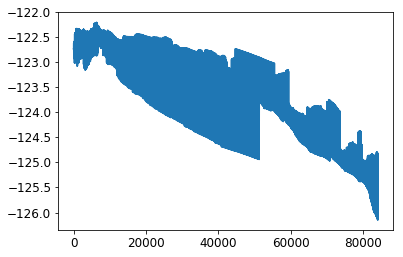

In [22]:
plt.plot(ds.longitude)

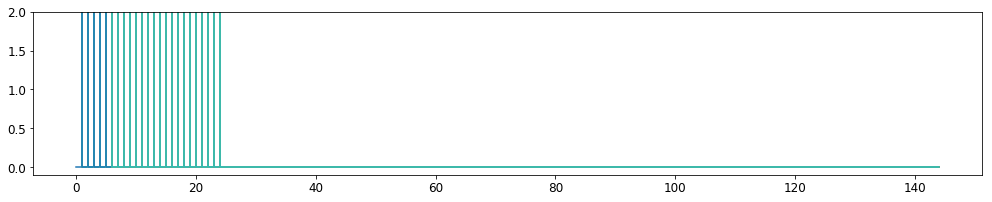

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(17, 3))
for drifter in range(0, 240):
    ax.plot(ds.land_binary_mask[drifter, :])
ax.set_ylim([-0.1, 2])
plt.show()

In [55]:
ds.x_sea_water_velocity[1, :]

<xarray.DataArray 'x_sea_water_velocity' (time: 145)>
array([ 9.969210e+36, -2.368006e-01, -1.748222e-01, -2.320719e-01,
       -3.158418e-01, -2.274024e-01, -5.016838e-02, -1.861265e-02,
       -5.600769e-02, -7.851733e-02, -7.569011e-02, -6.688570e-02,
       -8.773617e-02, -1.321741e-01, -1.828673e-01, -2.225510e-01,
       -2.243729e-01, -1.992485e-01, -1.673187e-01, -1.519401e-01,
       -1.073130e-01, -3.378668e-02,  1.519148e-02,  2.987875e-02,
        0.000000e+00,  6.178965e-02,  5.685326e-02,  5.053119e-02,
        2.551778e-02, -1.732368e-03, -9.600463e-04,  2.166511e-02,
        5.787198e-02,  9.842663e-02,  1.603109e-01,  2.259044e-01,
        2.343280e-01,  2.474219e-01,  1.537416e-01,  4.996288e-02,
       -1.393682e-02, -2.874237e-02, -3.768514e-02, -3.112798e-02,
        3.902883e-03,  5.292270e-02,  1.176603e-01,  1.661403e-01,
        0.000000e+00,  1.975302e-01,  8.189376e-02, -8.931448e-02,
       -1.940512e-01, -2.450512e-01, -2.465764e-01, -2.431418e-01,
       -

***

## Vector Rotation

From Hauke

In [23]:
o.add_reader([reader_NEMO, reader_HRDPS])

In [14]:
# Rotation from Hauke
prefix = make_prefix(date, paths)
fn_out = os.path.join(paths['out'], 'rotated_Hauke.nc')
r = rotate_fields()
r.rotate_fields(prefix + '_grid_U.nc', prefix + '_grid_V.nc', os.path.join(paths['out'], 'rotated_Hauke.nc'), 'SSC')

getting grid rotation coefficients
rotating
unstaggering
saving


In [24]:
o.seed_elements(-123.5, 49.2, radius=500, number=100, time=reader_NEMO.start_time, wind_drift_factor=0.03)

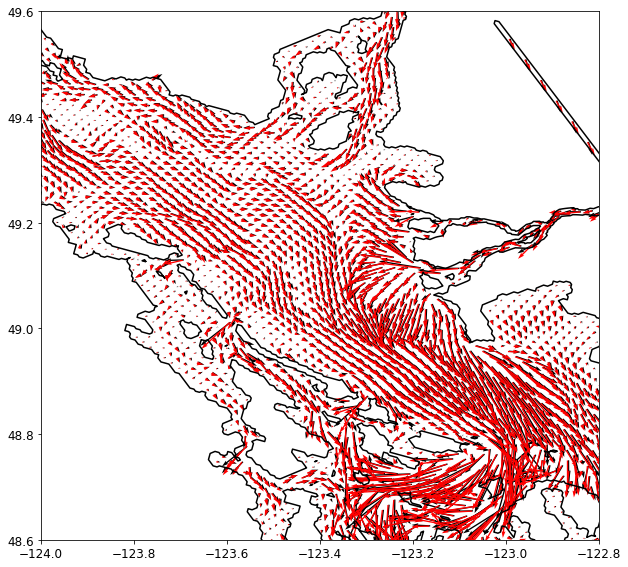

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim([-124, -122.8])
ax.set_ylim([48.6, 49.6])
viz_tools.set_aspect(ax)
ax.contour(mask.nav_lon, mask.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
for fn, u_key, v_key, color in zip([fn_out, NEMO_out], ['x_sea_water_velocity', 'u'], ['y_sea_water_velocity', 'v'], ['k', 'r']):
    with xr.open_dataset(fn).isel(time_counter=0) as data:
        u = np.ma.masked_where(data.meshmask == 0, data[u_key])[::10]
        v = np.ma.masked_where(data.meshmask == 0, data[v_key])[::10]
        q = ax.quiver(data.longitude[::10], data.latitude[::10], u, v, scale=20, color=color)